# Introduction

TODO: add here introductary description of the project

# Imports and Data

In [72]:

import pandas as pd
import numpy as np
from config import DATASET_NAME
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [73]:
from utils.plotting import plot_hist,plot_bar,barh_percent,plot_box,plot_boxes
from utils.evaluation import train_binary_classifier,make_logreg_pipeline
from utils.chategorize import categorize_bp

In [74]:
DATASET_NAME.parent / "train.csv"

PosixPath('/Users/lizarabkina/PythonProjects/Cardio/data/train.csv')

In [75]:
df = pd.read_csv(DATASET_NAME, sep=";")

In [76]:
original_df = df.copy()
original_df.shape

(70000, 13)

In [77]:
df = original_df.copy() # working df


# Data Cleaning


In [78]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [79]:
df.shape,df.columns


((70000, 13),
 Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
        'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
       dtype='object'))

Columns - Features:
- age - in days (convert to years)
- gender - 1/2 (female/male)
- height - in cm
- weight - in kg
- ap_hi,ap_lo - systolic/diastolic blood pressure
- cholesterol,glucose - levels (normal, 2: above normal, 3: well above normal )
- smoke,alco,active - binary lifestyle features
- cardio - target (1 = disease,0 = no disease)


In [80]:
print("Missing values:\n",df.isnull().sum())

Missing values:
 id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


- We have no Null values

We remove id because it doesn't have any meaning.

In [81]:
df = df.drop(columns=['id'])

In [82]:
print(f"Dataset contains {df.duplicated().sum()} duplicates.")

Dataset contains 24 duplicates.


In [83]:
duplicated = df[df.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
10494,16937,2,170,70.0,120,80,1,1,0,0,0,0
44653,16937,2,170,70.0,120,80,1,1,0,0,0,0
1142,17493,2,169,74.0,120,80,1,1,0,0,1,1
50432,17493,2,169,74.0,120,80,1,1,0,0,1,1
32683,17535,2,165,65.0,120,80,1,1,0,0,1,0


In [84]:
df.drop_duplicates(keep="first", inplace =True)
print(f"After removal of duplicates total of {df.shape[0]} rows and {df.shape[1]} columns remained.")

After removal of duplicates total of 69976 rows and 12 columns remained.


# EDA

## Quick Data Checks

- Check data types

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69976 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  int64  
 1   gender       69976 non-null  int64  
 2   height       69976 non-null  int64  
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  int64  
 5   ap_lo        69976 non-null  int64  
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


- Check missing data and duplicates

- Basic statistics

In [86]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,69976.0,19468.950126,2467.374620,10798.0,17664.0,19703.0,21327.0,23713.0
gender,69976.0,1.349648,0.476862,1.0,1.0,1.0,2.0,2.0
height,69976.0,164.359152,8.211218,55.0,159.0,165.0,170.0,250.0
weight,69976.0,74.208519,14.397211,10.0,65.0,72.0,82.0,200.0
ap_hi,69976.0,128.820453,154.037729,-150.0,120.0,120.0,140.0,16020.0
ap_lo,69976.0,96.636261,188.504581,-70.0,80.0,80.0,90.0,11000.0
cholesterol,69976.0,1.366997,0.680333,1.0,1.0,1.0,2.0,3.0
gluc,69976.0,1.226535,0.572353,1.0,1.0,1.0,1.0,3.0
smoke,69976.0,0.088159,0.283528,0.0,0.0,0.0,0.0,1.0
alco,69976.0,0.053790,0.225604,0.0,0.0,0.0,0.0,1.0


- Target balance

In [87]:
print("Target groups (absolute values):",df["cardio"].value_counts())
print("_______________________________")
print("Target groups (%):",df["cardio"].value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

Target groups (absolute values): cardio
0    35004
1    34972
Name: count, dtype: int64
_______________________________
Target groups (%): cardio
0    50.02%
1    49.98%
Name: proportion, dtype: object


Observation: Positive class (cardio disease) = 49.7% -> mild imbalance.

- Convert age to years and create BMI

In [88]:
df["age_years"]= (df["age"] / 365).round().astype(int)
df["bmi"] = (df["weight"] / (df["height"]/100)**2).round(1)

In [89]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,22.0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.9
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.5
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.7
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.0


In [90]:
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    print(f"\n{col}")
    print(f"Min: {df[col].min()},  Max: {df[col].max()},  Unique: {df[col].nunique()}")



age
Min: 10798,  Max: 23713,  Unique: 8076

gender
Min: 1,  Max: 2,  Unique: 2

height
Min: 55,  Max: 250,  Unique: 109

weight
Min: 10.0,  Max: 200.0,  Unique: 287

ap_hi
Min: -150,  Max: 16020,  Unique: 153

ap_lo
Min: -70,  Max: 11000,  Unique: 157

cholesterol
Min: 1,  Max: 3,  Unique: 3

gluc
Min: 1,  Max: 3,  Unique: 3

smoke
Min: 0,  Max: 1,  Unique: 2

alco
Min: 0,  Max: 1,  Unique: 2

active
Min: 0,  Max: 1,  Unique: 2

cardio
Min: 0,  Max: 1,  Unique: 2

age_years
Min: 30,  Max: 65,  Unique: 28

bmi
Min: 3.5,  Max: 298.7,  Unique: 494


In [91]:
#

In [92]:
# rules = (
#     (df["age_years"].between(18, 90)) &
#     (df["height"].between(120, 220)) &
#     (df["weight"].between(30, 250)) &
#     (df["ap_hi"].between(70, 250)) &
#     (df["ap_lo"].between(40, 150)) &
#     (df["ap_hi"] >= df["ap_lo"])
# )
# clean = df[rules].copy()
# print("Kept:", clean.shape, "Removed:", df.shape[0]-clean.shape[0])

In [93]:
# import numpy as np

# def count_outliers_iqr(df, cols=None, k=1.5):
#     """
#     Count outliers per column using IQR method.
    
#     Parameters:
#         df : DataFrame
#         cols : list of columns to check (default: all numeric)
#         k : multiplier for IQR (default 1.5)
#     """
#     if cols is None:
#         cols = df.select_dtypes(include=np.number).columns

#     for col in cols:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower, upper = Q1 - k*IQR, Q3 + k*IQR
#         n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
#         print(f"{col:<10}: {n_outliers} outliers")


#### Weight& BMI cut off

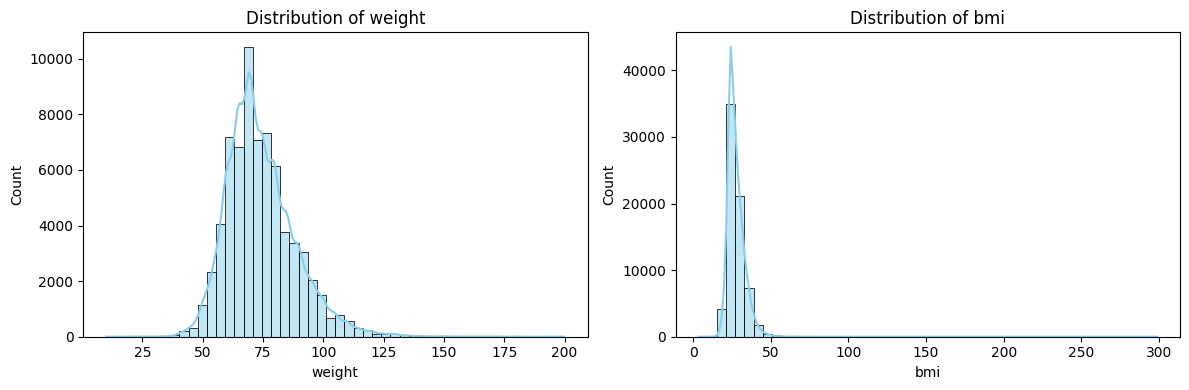

In [94]:
plot_hist(df,["weight","bmi"])

In [95]:
pd.set_option('display.max_rows', None)
df[df["bmi"]<12].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
18559,18140,1,160,30.0,120,80,1,1,0,0,1,1,50,11.7
16906,17272,2,170,31.0,150,90,2,2,0,0,1,1,47,10.7
60699,18875,1,171,29.0,110,70,2,1,0,0,1,1,52,9.9
26806,23284,1,157,23.0,110,80,1,1,0,0,1,0,64,9.3
60188,21855,1,162,21.0,120,80,2,1,0,0,1,1,60,8.0


In [96]:
df[df["bmi"]>60].sort_values(by = "bmi",ascending=False).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,54,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,42,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52,191.7


#### Height and Age cut off

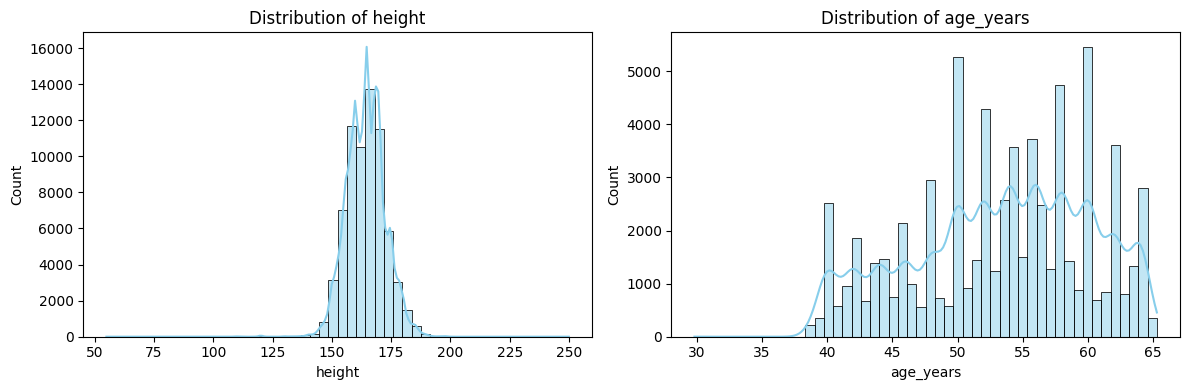

<function utils.plotting.plot_hist(df: pandas.core.frame.DataFrame, columns: list[str], bins=50, color='skyblue', jitter=False, edgecolor='black')>

In [97]:
plot_hist(df,["height","age_years"],bins = 50,color = "skyblue",jitter = True)
plot_hist

In [98]:
df[df["height"]<140].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,54,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,42,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52,191.7


#### Blood pressure values (ap_hi/ap_lo) cut off

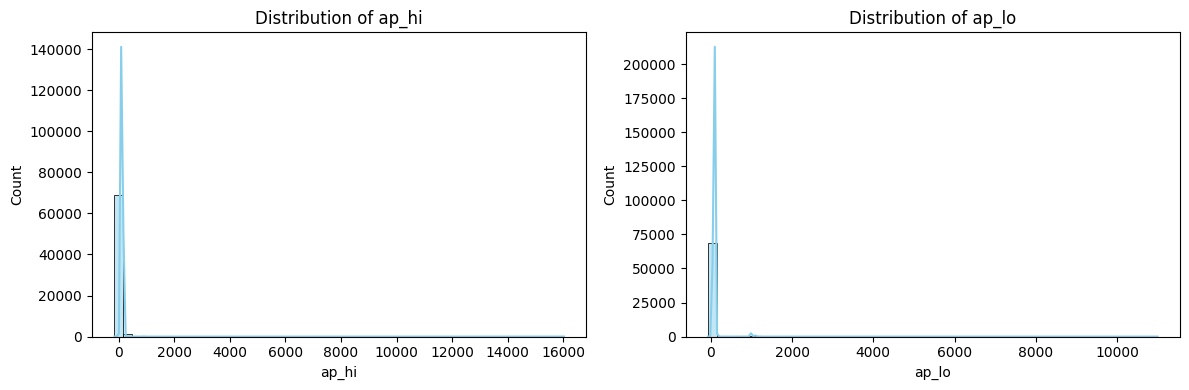

In [99]:
plot_hist(df,["ap_hi","ap_lo"])

## Dataset after cleaning

- Blood_pressure

In [100]:

# 1. Coerce to numeric
df[["ap_hi", "ap_lo"]] = df[["ap_hi", "ap_lo"]].apply(pd.to_numeric, errors="coerce")

# 2. Fix reversed values (if diastolic > systolic)
swap = df["ap_lo"] > df["ap_hi"]
df.loc[swap, ["ap_hi", "ap_lo"]] = df.loc[swap, ["ap_lo", "ap_hi"]].to_numpy()

# 3. Handle typos like 1000 → 100 (divide only if it makes sense)
mask_too_big = df["ap_lo"] >= 300
df.loc[mask_too_big, "ap_lo"] = df.loc[mask_too_big, "ap_lo"] / 10

mask_too_big_hi = df["ap_hi"] >= 300
df.loc[mask_too_big_hi, "ap_hi"] = df.loc[mask_too_big_hi, "ap_hi"] / 10

# 4. Keep only realistic values
ok = (
    df["ap_hi"].between(80, 250) &
    df["ap_lo"].between(40, 150) &
    (df["ap_hi"] >= df["ap_lo"] + 5)
)

# 5. Make sure values are not negative

df = df[(df["ap_hi"] > 0) & (df["ap_lo"] > 0)].copy()
df["ap_hi"] = df["ap_hi"].round().astype("Int64")
df["ap_lo"] = df["ap_lo"].round().astype("Int64")

df = df[ok].copy()




/var/folders/zs/lhn3v0dx0v32gt7hm_r0m1zc0000gn/T/ipykernel_35673/3862512772.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 110.   100.    80.   100.   100.   103.3  100.   100.   110.   100.
  100.   110.   100.   100.1  100.   100.   100.   100.   100.   120.
  110.   110.   100.   100.   100.    90.2  100.    90.6  110.   110.
  110.   110.   100.   100.  1000.   100.   100.1  100.   100.   100.
  100.   100.   100.   100.   120.   100.   100.   804.4  104.4  100.
  100.   100.   100.   110.   100.   110.   100.   110.   100.   100.
  110.   110.   100.   100.   100.   110.   100.   100.    90.9  100.
  100.   100.   100.   100.   100.   100.   100.   100.   100.   110.
  100.   100.   100.   100.   100.   100.   100.   110.   100.   100.
  110.   100.   100.   100.   100.   110.   100.   910.   103.3  110.
  100.   100.   100.   110.   100.   100.   110.    90.2  120.   110.
  100.   100.   11

- Height + BMI


In [101]:
keep_height_bmi = pd.Series(True, index=df.index)
if "height" in df.columns:
    keep_height_bmi &= df["height"].between(140, 200)   
if "bmi" in df.columns:
    keep_height_bmi &= df["bmi"].between(12, 60)
df = df[keep_height_bmi].copy()

- Age

In [102]:
if "age_years" in df.columns:
    df = df[df["age_years"].between(18, 90)].copy()

#### Number of rows after cleaning

In [103]:
print(f"Rows before cleaning: {len(original_df)}")
print(f"Rows after filtering: {len(df)}")
print(f"Removed rows: {len(original_df) - len(df)}")

Rows before cleaning: 70000
Rows after filtering: 68589
Removed rows: 1411


In [104]:
df_clean = df.copy()

In [105]:
df_clean.shape

(68589, 14)

Notes / Justification (one-liners for your report)

Height 140–200 cm & BMI 12–60: adult-plausible bounds to remove unit/entry errors while keeping real extremes.

BP rules: physiology-first (ap_hi 80–250, ap_lo 40–150, systolic > diastolic)

Age 18–90: adults


In [106]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,22.0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.9
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.5
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.7
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.0


## Plots

#### Gender

In [107]:
df_clean["gender_label"] = df["gender"].replace({1: "Male", 2: "Female"})

In [108]:
gender_counts = df_clean["gender_label"].value_counts().rename_axis("gender_label").reset_index(name="count")
gender_counts

,gender_label,count
0,Male,44658
1,Female,23931


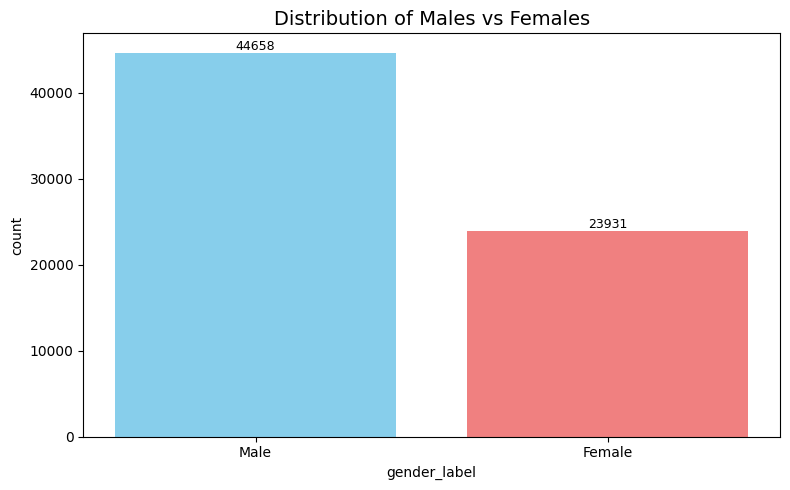

In [109]:
plot_bar(gender_counts,"gender_label","count",title ="Distribution of Males vs Females", color =["skyblue","lightcoral"])

In [110]:

bins = [-np.inf, 18.5, 25, 30, 35, 40, np.inf]
labels = ["Underweight", "Normal", "Overweight",
          "Obesity I", "Obesity II", "Obesity III"]

df_clean["bmi_bin"] = pd.cut(
    df_clean["bmi"],
    bins=bins,
    labels=labels,
    right=False,           
    include_lowest=True
).astype("category").cat.set_categories(labels, ordered=True)


### BMI category

In [111]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,gender_label,bmi_bin
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,22.0,Female,Normal
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.9,Male,Obesity I
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.5,Male,Normal
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.7,Female,Overweight
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.0,Male,Normal


In [112]:
bmi_counts = (
    df_clean["bmi_bin"]
    .value_counts()                     
    .rename_axis("bmi_bin")          
    .reset_index(name="count")          
    .sort_values("bmi_bin")             
)

In [113]:
bmi_order =[
    "Underweight",
    "Normal",
    "Overweight",
    "Obesity I",
    "Obesity II",
    "Obesity III"
][::-1]

In [114]:
bmi_colors = [
    "#AFF8CC",
    "#4CAF50",  
    "#FFC107",  
    "#FF9800",  
    "#F44336", 
    "#9C27B0"   
][::-1]


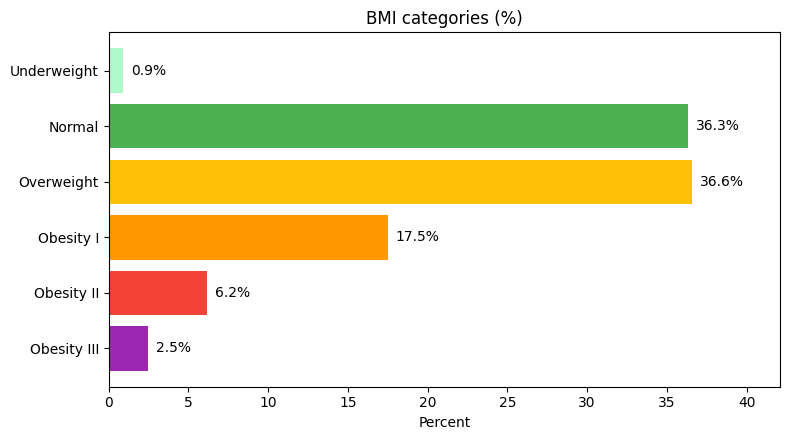

In [115]:
barh_percent(df_clean,"bmi_bin",order = bmi_order,title="BMI categories (%)",palette = bmi_colors)

### Blood pressure category

In [116]:
df_clean["bp_category"]=df_clean.apply(categorize_bp,axis=1)
df_clean["bp_category"].unique()

array(['Hypertension Stage 1', 'Hypertension Stage 2', 'Normal',
       'Elevated', 'Hypertensive Crisis'], dtype=object)

In [117]:
bp_order = [
    "Normal",
    "Elevated",
    "Hypertension Stage 1",
    "Hypertension Stage 2",
    "Hypertensive Crisis"
]

In [118]:
bp_colors = [
    "#4CAF50",  
    "#FFC107",  
    "#FF9800",  
    "#F44336", 
    "#9C27B0"   
]


In [119]:
bp_counts = (
    df_clean["bp_category"]
    .value_counts()
    .reindex(bp_order)    
    .dropna()            
)

In [120]:
bp_counts2 = (
    df_clean["bp_category"]
    .value_counts()
    .rename_axis("bp_category")
    .reset_index(name="count")
)

bp_counts2["bp_category"] = pd.Categorical(bp_counts2["bp_category"], categories=bp_order, ordered=True)
bp_counts2 = bp_counts2.sort_values("bp_category")

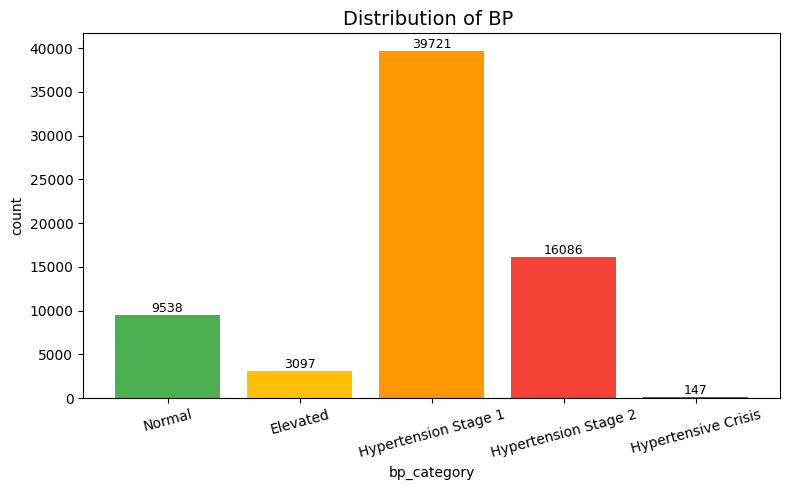

In [121]:
plot_bar(bp_counts2,"bp_category","count",title ="Distribution of BP ", color = bp_colors,rotation = 15)

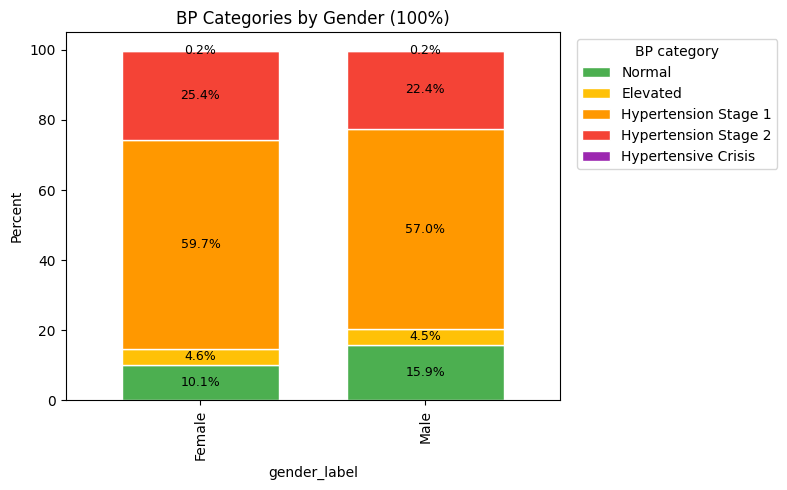

In [122]:
ct = pd.crosstab(df_clean["gender_label"],
                 pd.Categorical(df_clean["bp_category"], categories=bp_order, ordered=True),
                 normalize="index") * 100

ax = ct.plot(kind="bar", stacked=True, figsize=(8,5), color=bp_colors, edgecolor="white", width=0.7)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", fontsize=9, color="black")
plt.ylabel("Percent"); plt.title("BP Categories by Gender (100%)")
plt.legend(title="BP category", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

Women have a higher prevalence of hypertension (both Stage 1 and Stage 2 combined) compared to men,
while men are somewhat more represented in the normal and elevated blood pressure ranges.

In [123]:
df_clean["is_hypertensive"] = df_clean["bp_category"].isin(
    ["Hypertension Stage 1", "Hypertension Stage 2"]
)
hypertension_rate = (
    df_clean.groupby("gender_label")["is_hypertensive"]
    .mean().round(2) * 100
).reset_index(name="percent_hypertensive")
hypertension_rate



,gender_label,percent_hypertensive
0,Female,85.0
1,Male,79.0


/var/folders/zs/lhn3v0dx0v32gt7hm_r0m1zc0000gn/T/ipykernel_35673/3377660319.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


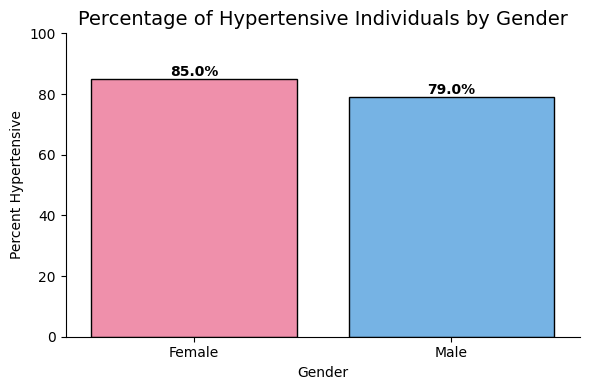

In [124]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=hypertension_rate,
    x="gender_label",
    y="percent_hypertensive",
    palette=["#FF80A4", "#64B5F6"],
    edgecolor="black"
)


for i, val in enumerate(hypertension_rate["percent_hypertensive"]):
    plt.text(i, val + 1, f"{val:.1f}%", ha="center", fontsize=10, fontweight="bold")

plt.title("Percentage of Hypertensive Individuals by Gender", fontsize=14)
plt.ylabel("Percent Hypertensive")
plt.xlabel("Gender")
plt.ylim(0, 100)
sns.despine()
plt.tight_layout()
plt.show()

In [125]:
# make bp_category -> categorical variable
df_clean["bp_category"] = pd.Categorical(
    df_clean["bp_category"],
    categories=bp_order,
    ordered=True
)

In [126]:
""" Labeling if person has CVD or not"""
df_clean["cardio_label"]=df_clean["cardio"].map({0:"No CVD",1:"CVD"})

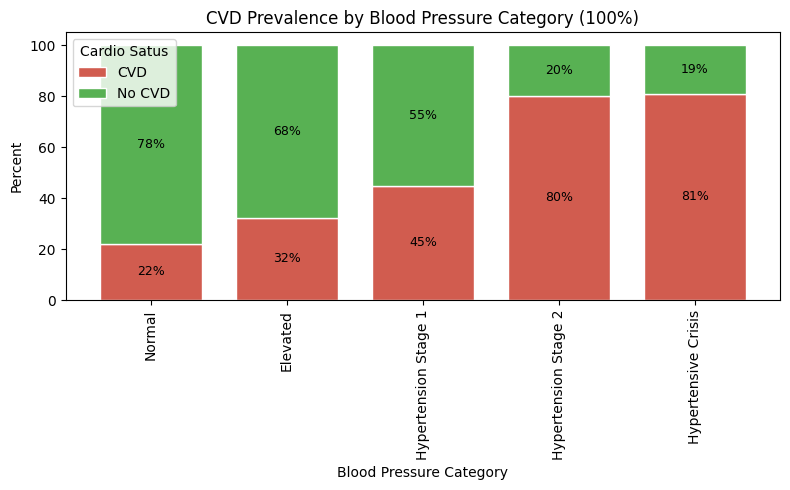

In [127]:
ct = pd.crosstab(df_clean["bp_category"], df_clean["cardio_label"], normalize="index") * 100
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5),
             color=["#D15C4F","#58B153"], edgecolor="white", width=0.75,)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f%%", label_type="center", fontsize=9, color="black")

plt.title("CVD Prevalence by Blood Pressure Category (100%)")
plt.ylabel("Percent"); plt.xlabel("Blood Pressure Category")
plt.legend(title="Cardio Satus"); plt.tight_layout(); plt.show()

#### Age

In [128]:
age_bins  = [18, 30, 40, 50, 60, 70, 80, 120]
age_names = ["18-29","30-39","40-49","50-59","60-69","70-79","80+"]
df_clean["age_bin"] = pd.cut(df_clean["age_years"], bins=age_bins, labels=age_names, right=False)

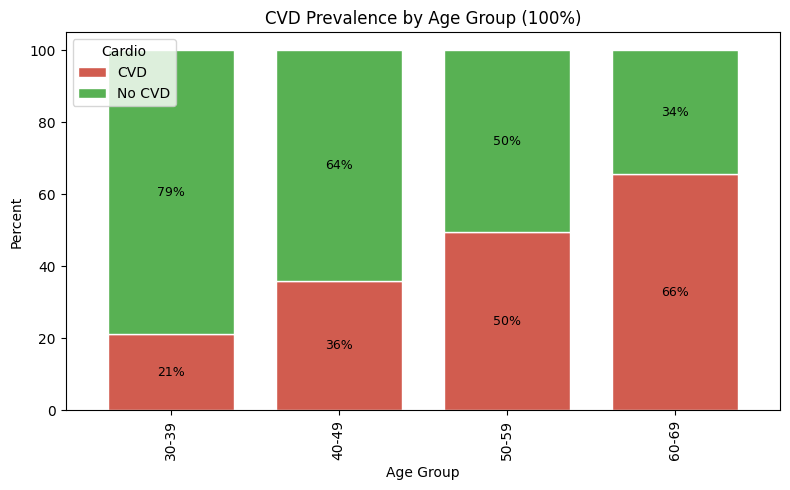

In [129]:
ct = pd.crosstab(df_clean["age_bin"], df_clean["cardio_label"], normalize="index") * 100
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5),
             color=["#D15C4F","#58B153"], edgecolor="white", width=0.75)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f%%", label_type="center", fontsize=9, color="black")

plt.title("CVD Prevalence by Age Group (100%)")
plt.ylabel("Percent"); plt.xlabel("Age Group")
plt.legend(title="Cardio"); plt.tight_layout(); plt.show()

<Axes: xlabel='age_years', ylabel='count'>

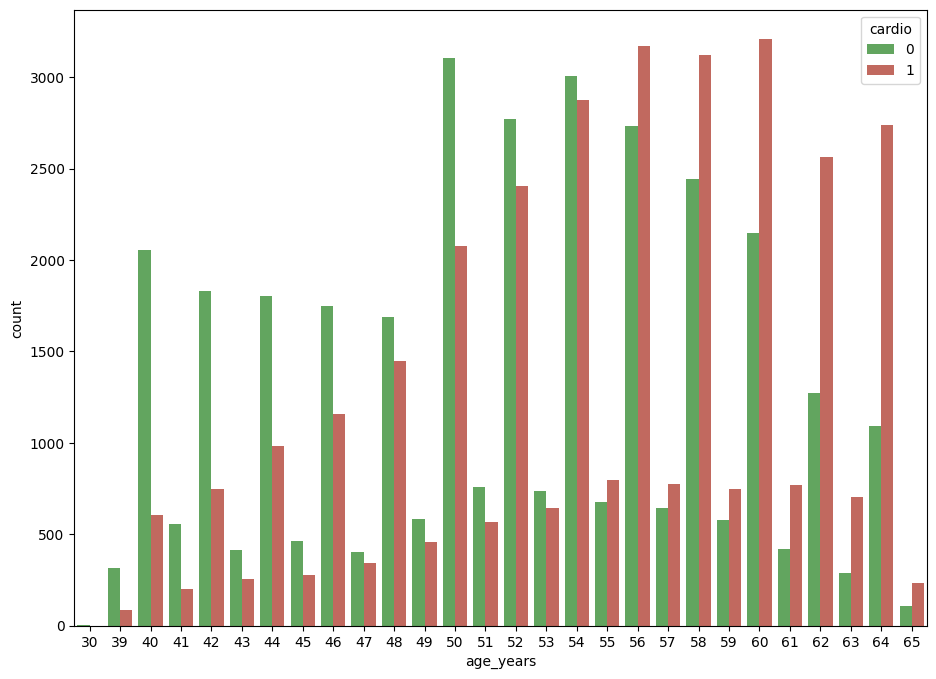

In [130]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='age_years', hue='cardio', data = df_clean, palette=["#58B153","#D15C4F"])

In [131]:
df_clean["gender_norm"]=df_clean["gender"]-1

<Axes: >

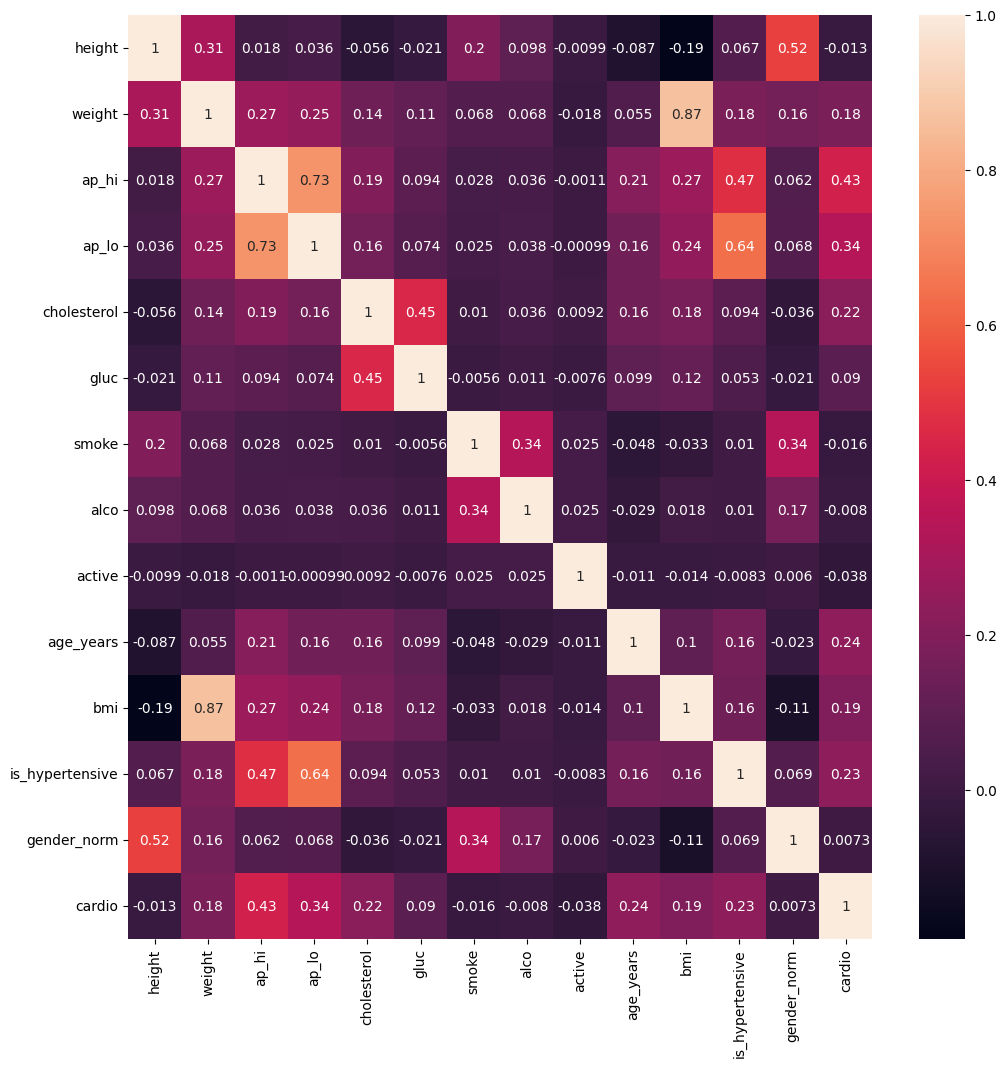

In [132]:
df_clean_num = df_clean.drop(columns=["age", "gender","gender_label","bp_category","cardio_label","age_bin", "bmi_bin"])
cols = [col for col in df_clean_num.columns if col!= 'cardio'] + ['cardio']
df_clean_num = df_clean_num[cols]
plt.figure(figsize=(12, 12))
sns.heatmap(df_clean_num.corr(), annot=True)

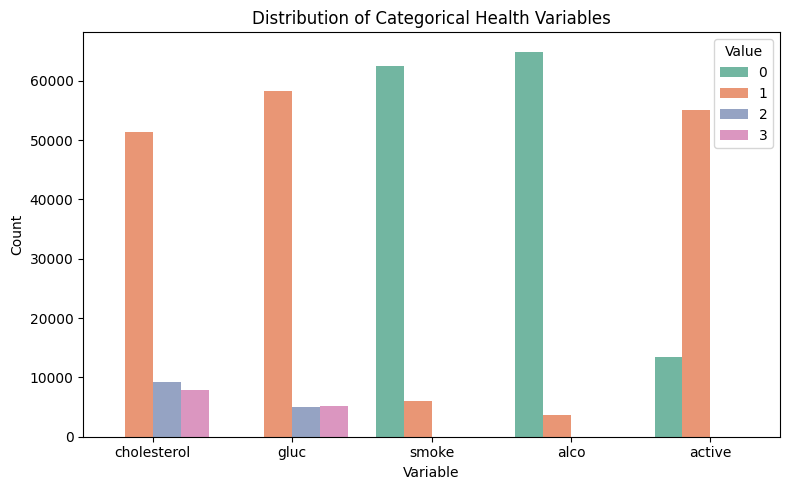

In [133]:
# distribution of categorical values
df_categorical = df_clean.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
plt.figure(figsize=(8,5))
sns.countplot(
    x="variable", hue="value",
    data=pd.melt(df_categorical),
    palette="Set2"
)
plt.title("Distribution of Categorical Health Variables")
plt.xlabel("Variable")
plt.ylabel("Count")
plt.legend(title="Value")
plt.tight_layout()
plt.show()

Observations:
- Cholesterol and Glucose- a lot of people with normal values
- Smoke and alco - majority of people don;t smoke and don't drink
- Active - a lot of people exercise but there are some people which don;t exercise


In [134]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,cardio,age_years,bmi,gender_label,bmi_bin,bp_category,is_hypertensive,cardio_label,age_bin,gender_norm
0,18393,2,168,62.0,110,80,1,1,0,0,...,0,50,22.0,Female,Normal,Hypertension Stage 1,True,No CVD,50-59,1
1,20228,1,156,85.0,140,90,3,1,0,0,...,1,55,34.9,Male,Obesity I,Hypertension Stage 2,True,CVD,50-59,0
2,18857,1,165,64.0,130,70,3,1,0,0,...,1,52,23.5,Male,Normal,Hypertension Stage 1,True,CVD,50-59,0
3,17623,2,169,82.0,150,100,1,1,0,0,...,1,48,28.7,Female,Overweight,Hypertension Stage 2,True,CVD,40-49,1
4,17474,1,156,56.0,100,60,1,1,0,0,...,0,48,23.0,Male,Normal,Normal,False,No CVD,40-49,0


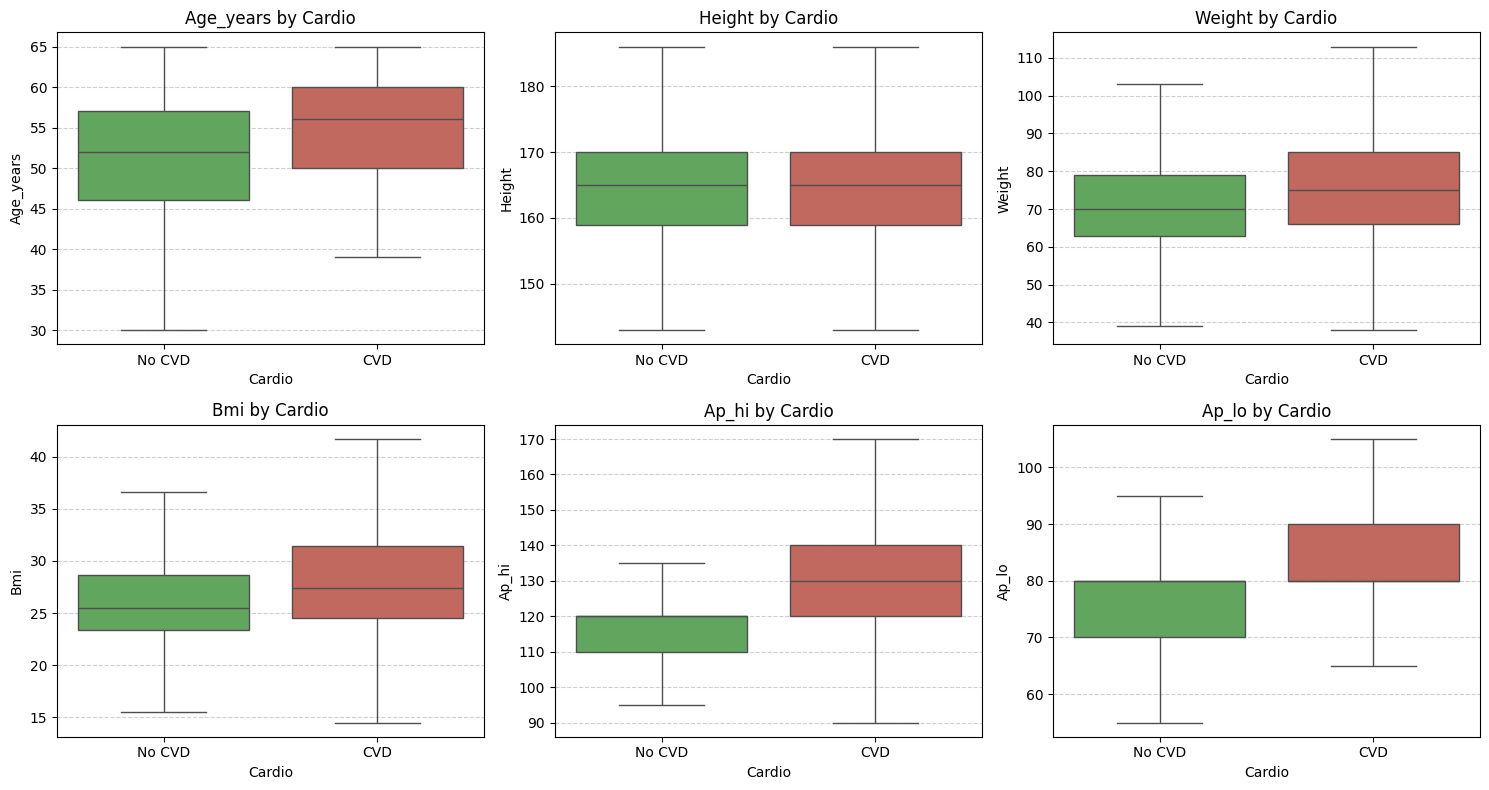

In [135]:
num_variables = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']
plot_boxes(df_clean,num_variables,palette =["#58B153","#D15C4F"],n_cols = 3)

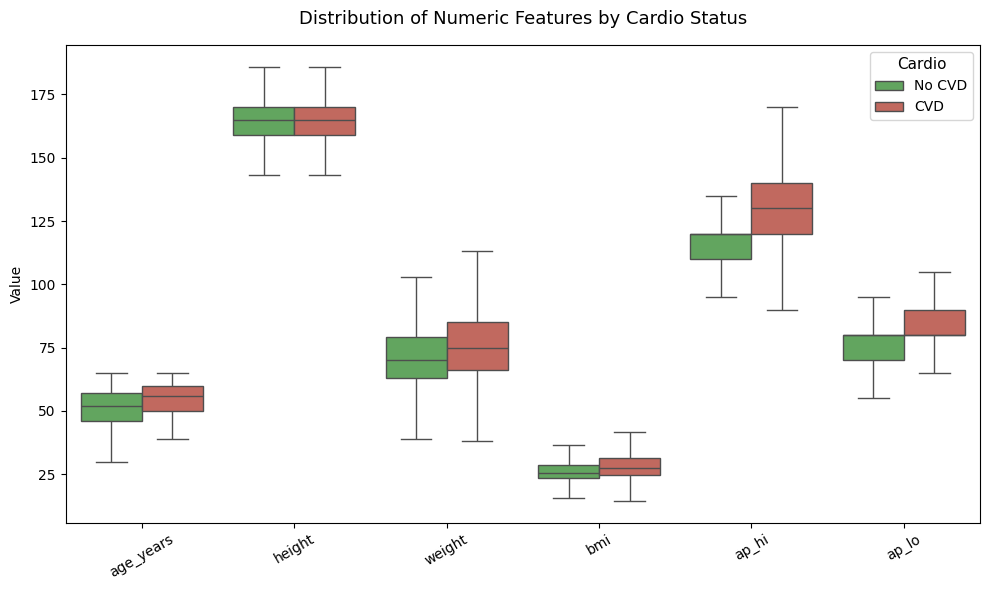

In [136]:

num_vars = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']

#  Melt the dataset into long format
df_melted = df_clean.melt(
    id_vars='cardio',
    value_vars=num_vars,
    var_name='Feature',
    value_name='Value'
)


df_melted['cardio'] = df_melted['cardio'].map({0: 'No CVD', 1: 'CVD'})

# Create the boxplot
plt.figure(figsize=(10,6))
sns.boxplot(
    x='Feature',
    y='Value',
    hue='cardio',
    data=df_melted,
    palette={'No CVD': "#58B153", 'CVD': "#D15C4F"},
    showfliers=False
)

#  Style the plot
plt.title('Distribution of Numeric Features by Cardio Status', fontsize=13, pad=15)
plt.xlabel('')
plt.ylabel('Value')
plt.xticks(rotation=30)
plt.legend(title='Cardio', title_fontsize=11, fontsize=10)
plt.tight_layout()
plt.show()


## Statistics

Null Hypothesis: There is no significant difference in the distribution of the num variables between individuals with and without cardiovascular disease (CVD).

Alternative Hypothesis: There is a significant difference in the distribution of the num variables between individuals with and without CVD.

In [137]:
# checking difference between distribution of num variables according to cardio_status
results = []

for col in num_variables:
    group0 = df_clean[df_clean['cardio'] == 0][col]
    group1 = df_clean[df_clean['cardio'] == 1][col]

    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')

    median0 = group0.median()
    median1 = group1.median()
    diff = median1 - median0

    results.append({
        'Variable': col.capitalize(),
        'Median (No CVD)': round(median0, 2),
        'Median (CVD)': round(median1, 2),
        'Median Diff': round(diff, 2),
        'U Statistic': round(stat, 2),
        'p-value': round(p, 5)
    })

summary_stat_df = pd.DataFrame(results)
summary_stat_df

,Variable,Median (No CVD),Median (CVD),Median Diff,U Statistic,p-value
0,Age_years,52.0,56.0,4.0,427475207.0,0.00000
1,Height,165.0,165.0,0.0,596636308.0,0.00085
2,Weight,70.0,75.0,5.0,465577370.5,0.00000
3,Bmi,25.5,27.4,1.9,453874573.0,0.00000
4,Ap_hi,120.0,130.0,10.0,292414912.0,0.00000
5,Ap_lo,80.0,80.0,0.0,363590138.0,0.00000


Reject Null Hypothesis. There is a significant differences between CVD and no CVD groups based on age,weight,BMI, ap_hi,ap_lo.

Null hypothesis: There is no association between cat variables and cardiovascular disease (CVD) status.

Alternative: There is an association between cat variables and cardiovascular disease (CVD) status.

In [138]:
#Association between cat_values and cardio_status

categorical_vars = ['cholesterol', 'gluc', 'smoke', 'alco', 'active']
results2 = []

for col in categorical_vars:
    contingency = pd.crosstab(df_clean[col], df_clean['cardio'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    k, r = contingency.shape
    cramer_v = np.sqrt((chi2 / n) / (min(k - 1, r - 1)))

    results2.append({
        'Variable': col,
        'Chi2': round(chi2, 2),
        'p-value': round(p, 5),
        'Cramér V': round(cramer_v, 3)
    })

pd.DataFrame(results2)


,Variable,Chi2,p-value,Cramér V
0,cholesterol,3365.39,0.00000,0.222
1,gluc,578.94,0.00000,0.092
2,smoke,17.86,0.00002,0.016
3,alco,4.26,0.03891,0.008
4,active,96.31,0.00000,0.037


Chi-square tests showed that cholesterol and glucose levels differ significantly between individuals with and without CVD (p < 0.001).
However, Cramér’s V indicates that only cholesterol exhibits a moderate practical association (V = 0.22), while glucose and lifestyle factors (smoking, alcohol, activity) show weak or negligible effects.

In [139]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,cardio,age_years,bmi,gender_label,bmi_bin,bp_category,is_hypertensive,cardio_label,age_bin,gender_norm
0,18393,2,168,62.0,110,80,1,1,0,0,...,0,50,22.0,Female,Normal,Hypertension Stage 1,True,No CVD,50-59,1
1,20228,1,156,85.0,140,90,3,1,0,0,...,1,55,34.9,Male,Obesity I,Hypertension Stage 2,True,CVD,50-59,0
2,18857,1,165,64.0,130,70,3,1,0,0,...,1,52,23.5,Male,Normal,Hypertension Stage 1,True,CVD,50-59,0
3,17623,2,169,82.0,150,100,1,1,0,0,...,1,48,28.7,Female,Overweight,Hypertension Stage 2,True,CVD,40-49,1
4,17474,1,156,56.0,100,60,1,1,0,0,...,0,48,23.0,Male,Normal,Normal,False,No CVD,40-49,0


#### Stratification Matrix

In [140]:
df_clean_summary3 = (
    df_clean
    .groupby(["age_bin", "bp_category"], observed=True)
    .agg(count=("cardio", "size"), cvd_rate=("cardio", "mean"))
    .reset_index()
)

df_clean_summary3.pivot(index="age_bin", columns="bp_category", values="cvd_rate")


bp_category,Normal,Elevated,Hypertension Stage 1,Hypertension Stage 2,Hypertensive Crisis
age_bin,,,,,
30-39,0.064000,0.172414,0.176768,0.720000,1.000000
40-49,0.143178,0.203905,0.324920,0.791170,0.758621
50-59,0.240643,0.332466,0.440138,0.793363,0.804878
60-69,0.427184,0.486043,0.612605,0.823842,0.852941


In [147]:
df_clean_summary3["cvd_rate"] = pd.to_numeric(df_clean_summary3["cvd_rate"], errors="coerce")

In [146]:
df_clean_final=df_clean.copy()